In [1]:
from numba import njit
import numpy as np
import math

from numba import njit, prange

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter

In [2]:
## plotting parameters
binary_colors = ['#F7FCF5', '#00441B']
binary_cmap = ListedColormap(binary_colors)

# Define a colormap for the values 0, 1, 2, 3 - different types of phase spaces
colors_bistability_colorbar = ['#F0E5D8', '#E17C55', '#8C2D34', '#2C3A63']
cmap = ListedColormap(colors_bistability_colorbar)

In [3]:
delE=4.5
Ka=1.4*10**(-4)
Ki=5.3*10**(-7)
K_c=Ka/Ki

@njit
def pAct(c, K_c=K_c, delE=delE):
    """ probability of repressor/activator being active

    Parameters:
        - c: inducer concentration
        - K_c: dissociation constant in active state / dissociation constant in inactive state
        - delE: energy difference between inactive and active state
    """

    p= (1 + c)**2 / ((1 + c)**2 + np.exp(-delE)*(1 + c*K_c)**2)
    return p

c_values = np.logspace(-7, -4, 1000)/Ka
p_values =  pAct(c_values)

K = 1
r = 2
omegaA = 7.5
omegaB = 7.5

In [4]:
@njit
def find_intersections(x, y1, y2):
    """
    Find intersections between two curves y1(x) and y2(x).

    Parameters:
    - x: 1D array of x values (must be sorted)
    - y1: 1D array of y values for the first curve
    - y2: 1D array of y values for the second curve

    Returns:
    - intersections: List of (x, y|) coordinates of intersection points
    """
    intersections = []
    for i in prange(len(x) - 1):
        # Check if the difference changes sign
        diff1 = y1[i] - y2[i]
        diff2 = y1[i + 1] - y2[i + 1]
        if diff1 * diff2 < 0:  # Sign change indicates an intersection
            # Linear interpolation to find the x-coordinate of the intersection
            x_intersect = x[i] - diff1 * (x[i + 1] - x[i]) / (diff2 - diff1)
            # Linear interpolation to find the y-coordinate of the intersection
            y_intersect = y1[i] + (y1[i + 1] - y1[i]) * (x_intersect - x[i]) / (x[i + 1] - x[i])
            intersections.append((x_intersect, y_intersect))
    return intersections



@njit
def steady_state(r, K, omegaA, omegaB, pactA, pactB, n_sampling=300):
  Btilde=np.linspace(0,r, n_sampling)
  fA=r/(1+2*pactB*Btilde+omegaB*(pactB*Btilde)**2)
  fm1B=(np.sqrt(1-omegaA*(1-r/Btilde))-1)/omegaA/(pactA/K)
  return find_intersections(Btilde, fA, fm1B)


In [5]:
@njit
def bistable_or_not_array(r, K, omegaA, omegaB, p_val_1 = p_values, p_val_2 = p_values):
  np1=len(p_val_1)
  np2=len(p_val_2)
  bs_bool = np.zeros((np1,np2), dtype=np.int64)
  for iA in prange(np1):
    pA = p_val_1[iA]
    for iB in prange(np2):
      pB = p_val_2[iB]
      Ass = steady_state(r, K, omegaA, omegaB, pA, pB)
      if len(Ass) == 1:
        bs_bool[iA, iB] = 0
      else:
        bs_bool[iA, iB] = 1 
  return bs_bool


@njit
def bistable_or_not(r, K, omegaA, omegaB, p_val_1 = p_values, p_val_2 = p_values):
  bs_bool = bistable_or_not_array(r, K, omegaA, omegaB, p_val_1, p_val_2)
  if np.sum(np.transpose(bs_bool)[:,0]) == 0 and np.sum(np.transpose(bs_bool)[0]) == 0:
     type_of_phase_space = 4
  if np.sum(np.transpose(bs_bool)[:,0]) == 0 and np.sum(np.transpose(bs_bool)[0]) != 0 :
     type_of_phase_space = 1
  if np.sum(np.transpose(bs_bool)[0]) == 0 and np.sum(np.transpose(bs_bool)[:,0]) != 0 :
     type_of_phase_space = 2
  if np.sum(np.transpose(bs_bool)[:,0]) != 0 and np.sum(np.transpose(bs_bool)[0]) != 0:
     type_of_phase_space = 3    
  if np.sum(bs_bool) == 0:
     type_of_phase_space = 0
  return bs_bool, type_of_phase_space

@njit
def type_of_phase_space_colorbar_K(r, K_list, omegaA, omegaB, p_val_1 = p_values, p_val_2 = p_values):
  n_K_list = len(K_list)
  t = np.zeros(n_K_list)
  for i in prange(n_K_list):
    bs_bool, type_of_phase_space = bistable_or_not(r, K_list[i], omegaA, omegaB, p_val_1, p_val_2)
    if type_of_phase_space == 4 and i>0:
        t[i] = t[i-1]
    else : 
        t[i] = type_of_phase_space
  return t

@njit
def type_of_phase_space_colorbar_omegaA(r, K, omegaA_list, omegaB, p_val_1 = p_values, p_val_2 = p_values):
  n_wA_list = len(omegaA_list)
  t = np.zeros(n_wA_list)
  for i in prange(n_wA_list):
    bs_bool, type_of_phase_space = bistable_or_not(r, K, omegaA_list[i], omegaB, p_val_1, p_val_2)
    if type_of_phase_space == 4 and i>0:
        t[i] = t[i-1]
    else : 
        t[i] = type_of_phase_space
  return t

@njit
def type_of_phase_space_colorbar_omegaB(r, K, omegaA, omegaB_list, p_val_1 = p_values, p_val_2 = p_values):
  n_wB_list = len(omegaB_list)
  t = np.zeros(n_wB_list)
  for i in prange(n_wB_list):
    bs_bool, type_of_phase_space = bistable_or_not(r, K, omegaA, omegaB_list[i], p_val_1, p_val_2)
    if type_of_phase_space == 4 and i>0:
        t[i] = t[i-1]
    else : 
        t[i] = type_of_phase_space
  return t


In [6]:
@njit
def bistable_or_not_phase_space(r, K, omegaA, omegaB, c_val=c_values):
  nc=len(c_val)
  bs_bool = np.zeros((nc,nc), dtype=np.int64)
  for iA in prange(nc):
    cA=c_val[iA]
    pA=pAct(cA)
    for iB in prange(nc):
      cB=c_val[iB]
      pB=pAct(cB)
      Ass = steady_state(r, K, omegaA, omegaB, pA, pB)
      if len(Ass) == 1:
        bs_bool[iA, iB] = 0
      else:
        bs_bool[iA, iB] = 1
  if np.sum(bs_bool) == 0:
     type_of_phase_space = 0
  elif np.sum(np.transpose(bs_bool)[:,0]) == 0 :
     type_of_phase_space = 1
  elif np.sum(np.transpose(bs_bool)[0]) == 0 :
     type_of_phase_space = 2
  return bs_bool, type_of_phase_space

## Color bar for varying $K$.

In [8]:
logK_min, logK_max = -3, 1
K_list = np.logspace(logK_min, logK_max, 100)

t_K = type_of_phase_space_colorbar_K(r, K_list, omegaA, omegaB)

In [9]:
# Find transition points (where type of phase space changes)
t_trans = []
for i in range(len(t_K)-1):
    if t_K[i] != t_K[i+1]:
        k = (K_list[i] + K_list[i+1]) / 2
        t_trans += [k]

# Add custom display values
K_display_phase_space = [np.min(K_list), 0.2, 1, 1.3, np.max(K_list)]
t_trans += K_display_phase_space

t_trans = np.sort(np.array(t_trans))

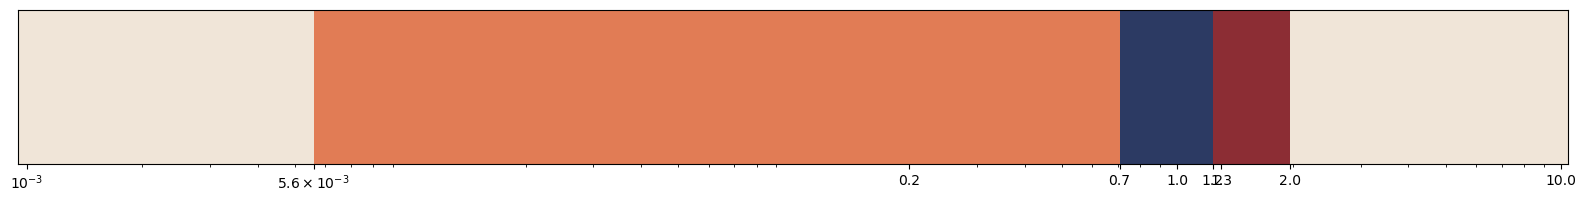

In [10]:
t_K_2d = np.vstack([t_K, t_K]) 

X = K_list
Y = [0, 1]

fig, ax = plt.subplots(figsize=(20, 2)) 
pcm = ax.pcolormesh(X, Y, t_K_2d, shading='auto', cmap=cmap)

ax.set_yticks([])
ax.set_xscale('log')

tick_positions = [1e-3, 5.6e-3] + t_trans[2:].tolist() 
ax.xaxis.set_major_locator(ticker.FixedLocator(tick_positions))
def sci_notation_format(x, _):
    if np.isclose(x, 1e-3):
        return r'$10^{-3}$'
    elif np.isclose(x, 5.6e-3):
        return r'$5.6 \times 10^{-3}$'
    else:
        return f'{x:.1f}'  # fallback formatting

ax.xaxis.set_major_formatter(FuncFormatter(sci_notation_format))

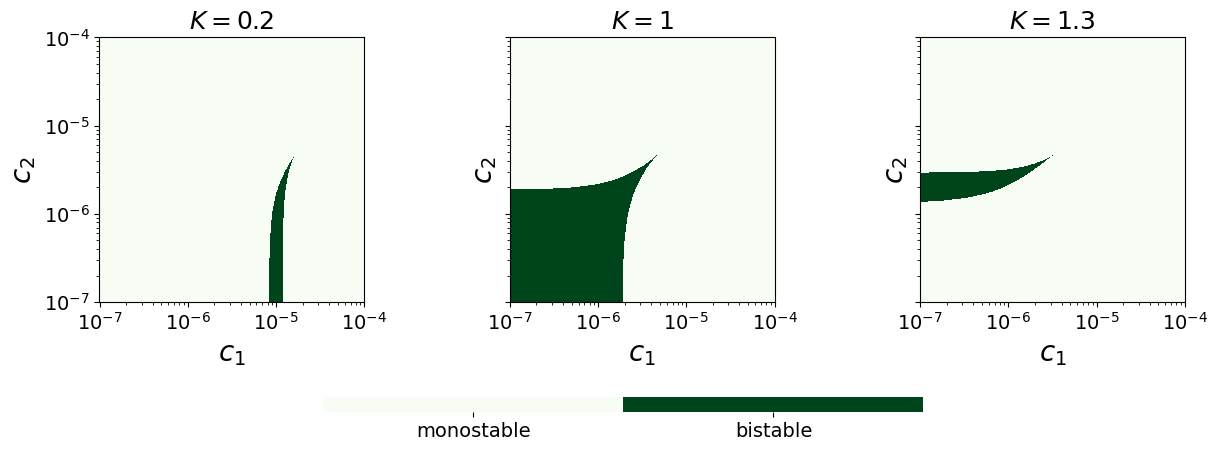

In [11]:
K_values = [0.2, 1, 1.3]
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

for i, Kval in enumerate(K_values):
    phase_space_bistability, type_of_phase_space = bistable_or_not_phase_space(r, Kval, omegaA, omegaB, c_val=c_values)
    
    ax = axes[i]
    pcm = ax.pcolormesh(Ka*c_values, Ka*c_values, np.transpose(phase_space_bistability), cmap=binary_cmap, shading='auto')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xticks([1e-7, 1e-6, 1e-5, 1e-4])
    ax.set_yticks([1e-7, 1e-6, 1e-5, 1e-4])
    ax.tick_params(labelsize=14)
    ax.set_title(f'$K={Kval}$', fontsize=18)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel(r'$c_1$', fontsize=20)
    ax.set_ylabel(r'$c_2$', fontsize=20)


plt.subplots_adjust(bottom=0.35)
cbar_ax = fig.add_axes([0.3, 0.13, 0.4, 0.03]) 
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal', ticks=[0.25, 0.75])
cbar.ax.set_xticklabels(['monostable', 'bistable'], fontsize=14)
cbar.outline.set_visible(False)



## Color bar for different $\omega_2$, $K=1$.

In [13]:
omegaB_list = np.logspace(0,6,100)
t_omegaB_K1 = type_of_phase_space_colorbar_omegaB(r, 1, omegaA, omegaB_list)

In [14]:
t_trans = []

# Find transition points (where type of phase space changes)
for i in range(len(t_omegaB_K1)-1):
    if t_omegaB_K1[i]!= t_omegaB_K1[i+1]:
        w = (omegaB_list[i] + omegaB_list[i+1])/2
        t_trans += [w]
        
# Add custom display values
omegaB_display_phase_space = [1, 3, 10, 100, np.max(omegaB_list)]
t_trans += omegaB_display_phase_space  

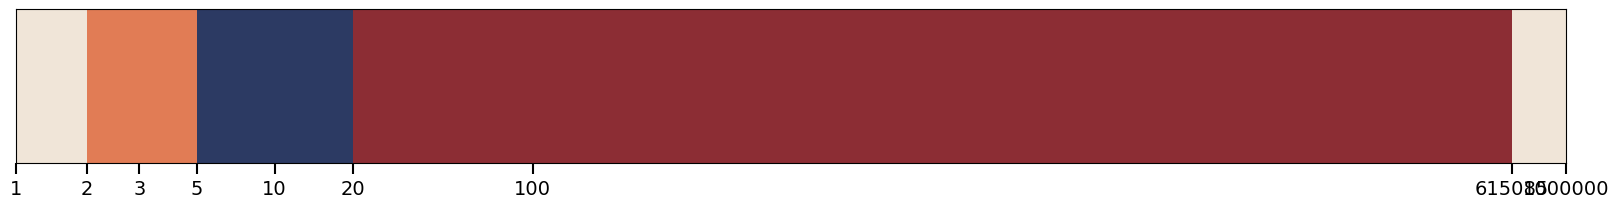

<Figure size 640x480 with 0 Axes>

In [15]:
t_omegaB_K1_2d = np.vstack([t_omegaB_K1, t_omegaB_K1])

X = omegaB_list
Y = [0, 1]

fig, ax = plt.subplots(figsize=(20, 2))  # wide and flat
pcm = ax.pcolormesh(X, Y, t_omegaB_K1_2d, shading='auto', cmap=cmap)

ax.set_yticks([])
ax.set_xscale('log')
tick_positions = t_trans
ax.xaxis.set_major_locator(ticker.FixedLocator(tick_positions))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.f'))
ax.tick_params(
    axis='x',
    which='major',
    direction='out',  
    length=8,           
    width=1.5,         
    labelsize=14
)
ax.tick_params(axis='x', which='minor', bottom=False, top=False)
ax.set_xlim((np.min(X),np.max(X)))
plt.show()
plt.tight_layout()

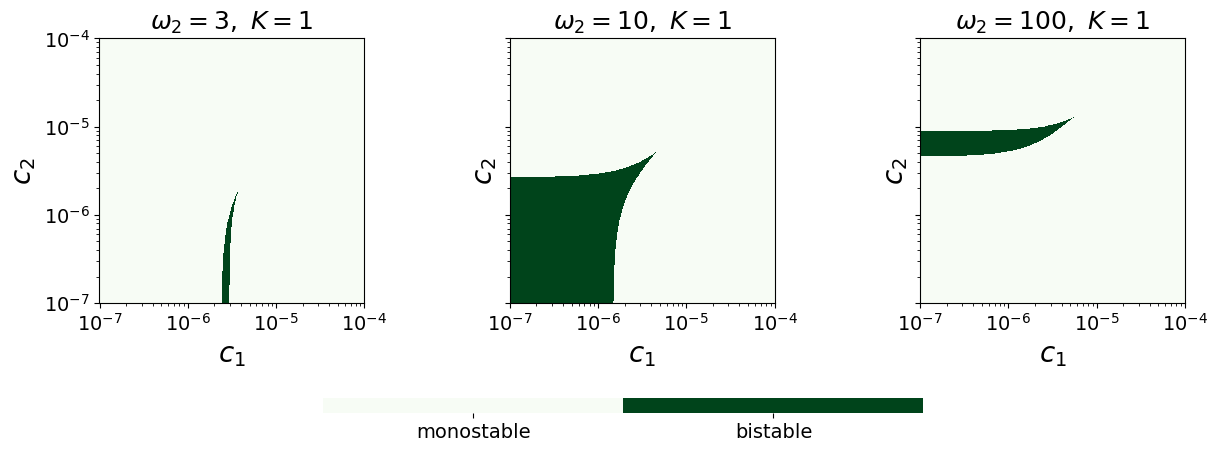

In [16]:
K=1
omega_values = [3,10,100]
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

for i, omegaval in enumerate(omega_values):
    phase_space_bistability, type_of_phase_space = bistable_or_not_phase_space(r, K, omegaA, omegaval, c_val=c_values)
    
    ax = axes[i]
    pcm = ax.pcolormesh(Ka*c_values, Ka*c_values, np.transpose(phase_space_bistability), cmap=binary_cmap, shading='auto')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xticks([1e-7, 1e-6, 1e-5, 1e-4])
    ax.set_yticks([1e-7, 1e-6, 1e-5, 1e-4])
    ax.tick_params(labelsize=14)
    ax.set_title(rf'$\omega_2={omegaval},\ K={K}$', fontsize=18)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel(r'$c_1$', fontsize=20)
    ax.set_ylabel(r'$c_2$', fontsize=20)


plt.subplots_adjust(bottom=0.35)
cbar_ax = fig.add_axes([0.3, 0.13, 0.4, 0.03]) 
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal', ticks=[0.25, 0.75])
cbar.ax.set_xticklabels(['monostable', 'bistable'], fontsize=14)
cbar.outline.set_visible(False)

## Color bar for varying $\omega_2$, $\ K=0.7$.

In [18]:
omegaA = 7.5
log10omegaB_min,log10omegaB_max = 0,7
omegaB_list = np.logspace(log10omegaB_min,log10omegaB_max,500)
t_omegaB_K07 = type_of_phase_space_colorbar_omegaB(2, 0.7, omegaA, omegaB_list)

In [19]:
t_trans = [] 

# Find transition points (where type of phase space changes)
for i in range(len(t_omegaB_K07)-1):
    if t_omegaB_K07[i]!= t_omegaB_K07[i+1]:
        w = (omegaB_list[i] + omegaB_list[i+1])/2
        t_trans += [w]
        
# Add custom display values
omegaB_display_phase_space = [1,5,50,np.max(omegaB_list)]
t_trans += omegaB_display_phase_space
t_trans = np.array(t_trans)  

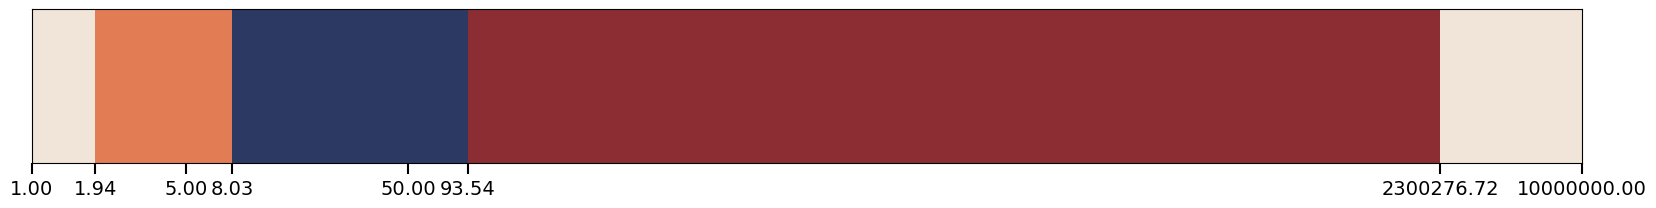

<Figure size 640x480 with 0 Axes>

In [20]:
t_omegaB_K07_2d = np.vstack([t_omegaB_K07, t_omegaB_K07]) 

X = omegaB_list
Y = [0, 1]

fig, ax = plt.subplots(figsize=(20, 2)) 
pcm = ax.pcolormesh(X, Y, t_omegaB_K07_2d, shading='auto', cmap=cmap)

ax.set_yticks([])
ax.set_xscale('log')
tick_positions = t_trans
ax.xaxis.set_major_locator(ticker.FixedLocator(tick_positions))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
ax.tick_params(
    axis='x',
    which='major',
    direction='out',  
    length=8,           
    width=1.5,         
    labelsize=14
)
ax.tick_params(axis='x', which='minor', bottom=False, top=False)
ax.set_xlim((np.min(X),np.max(X)))
plt.show()
plt.tight_layout()

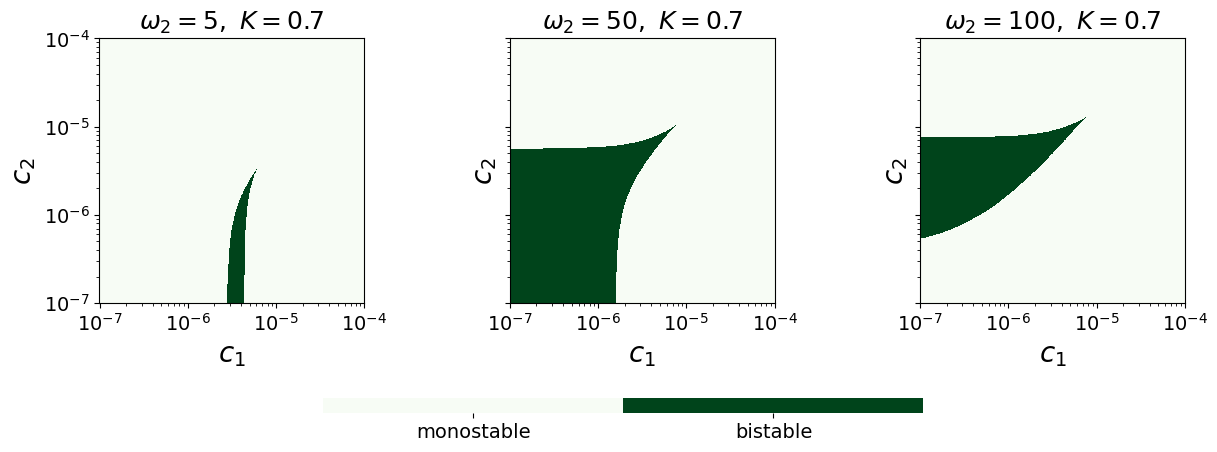

In [21]:
K=0.7
omega_values = [5,50,100]
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

for i, omegaval in enumerate(omega_values):
    phase_space_bistability, type_of_phase_space = bistable_or_not_phase_space(r, K, omegaA, omegaval, c_val=c_values)
    
    ax = axes[i]
    pcm = ax.pcolormesh(Ka*c_values, Ka*c_values, np.transpose(phase_space_bistability), cmap=binary_cmap, shading='auto')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xticks([1e-7, 1e-6, 1e-5, 1e-4])
    ax.set_yticks([1e-7, 1e-6, 1e-5, 1e-4])
    ax.tick_params(labelsize=14)
    ax.set_title(rf'$\omega_2={omegaval},\ K={K}$', fontsize=18)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel(r'$c_1$', fontsize=20)
    ax.set_ylabel(r'$c_2$', fontsize=20)


plt.subplots_adjust(bottom=0.35)
cbar_ax = fig.add_axes([0.3, 0.13, 0.4, 0.03]) 
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal', ticks=[0.25, 0.75])
cbar.ax.set_xticklabels(['monostable', 'bistable'], fontsize=14)
cbar.outline.set_visible(False)

## Color bar for different $\omega_1$, $K=0.7$.

In [23]:
omegaA_list = np.logspace(-1,6,500)
t_omegaA_K07 = type_of_phase_space_colorbar_omegaA(r, 0.7, omegaA_list, omegaB)

In [24]:
t_trans = []

# Find transition points (where type of phase space changes)
for i in range(len(t_omegaA_K07)-1):
    if t_omegaA_K07[i]!= t_omegaA_K07[i+1]:
        w = (omegaA_list[i] + omegaA_list[i+1])/2
        t_trans += [w]
        
# Add custom display values
omegaA_display_phase_space = [np.max(omegaA_list), 1, 3, 10, np.max(omegaA_list)]
t_trans += omegaA_display_phase_space  

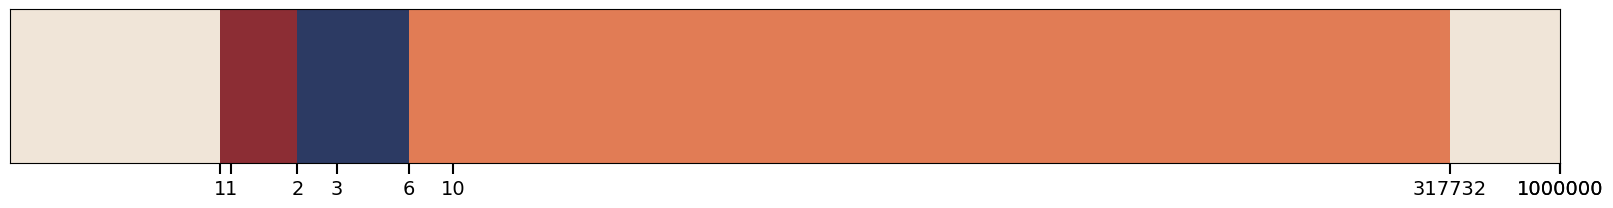

<Figure size 640x480 with 0 Axes>

In [25]:
t_omegaA_K07_2d = np.vstack([t_omegaA_K07, t_omegaA_K07])

X = omegaA_list
Y = [0, 1]

fig, ax = plt.subplots(figsize=(20, 2)) 
pcm = ax.pcolormesh(X, Y, t_omegaA_K07_2d, shading='auto', cmap=cmap)

ax.set_yticks([])
ax.set_xscale('log')
tick_positions = t_trans
ax.xaxis.set_major_locator(ticker.FixedLocator(tick_positions))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.f'))
ax.tick_params(
    axis='x',
    which='major',
    direction='out',   
    length=8,           
    width=1.5,         
    labelsize=14
)
ax.tick_params(axis='x', which='minor', bottom=False, top=False)
ax.set_xlim((np.min(X),np.max(X)))
plt.show()
plt.tight_layout()

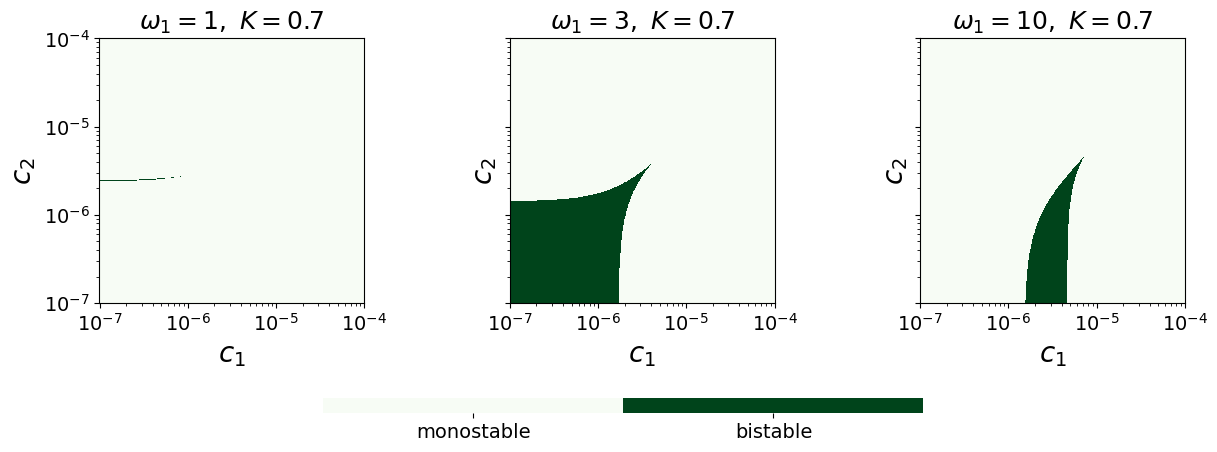

In [26]:
K=0.7
omegaB = 7.5
omega_values = [1,3,10]
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

for i, omegaval in enumerate(omega_values):
    phase_space_bistability, type_of_phase_space = bistable_or_not_phase_space(r, K, omegaval, omegaB, c_val=c_values)
    
    ax = axes[i]
    pcm = ax.pcolormesh(Ka*c_values, Ka*c_values, np.transpose(phase_space_bistability), cmap=binary_cmap, shading='auto', rasterized=True)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xticks([1e-7, 1e-6, 1e-5, 1e-4])
    ax.set_yticks([1e-7, 1e-6, 1e-5, 1e-4])
    ax.tick_params(labelsize=14)
    ax.set_title(rf'$\omega_1={omegaval},\ K={K}$', fontsize=18)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel(r'$c_1$', fontsize=20)
    ax.set_ylabel(r'$c_2$', fontsize=20)


plt.subplots_adjust(bottom=0.35)
cbar_ax = fig.add_axes([0.3, 0.13, 0.4, 0.03]) 
cbar = fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal', ticks=[0.25, 0.75])
cbar.ax.set_xticklabels(['monostable', 'bistable'], fontsize=14)
cbar.outline.set_visible(False)